In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import warnings
import numpy as np

warnings.filterwarnings('ignore')

In [80]:
df_A_fullday = pd.read_csv('processed_datasets/fulldata/A.csv')
df_A_daytime = pd.read_csv('processed_datasets/filtereddata/A.csv')
df_B_fullday = pd.read_csv('processed_datasets/fulldata/B.csv')
df_B_daytime = pd.read_csv('processed_datasets/filtereddata/B.csv')
df_A_daytime.head()

,Day_name,Date,Time,DateTime,Batch requests/sec,User connections,Processor Time,Free memory,Page reads/sec,Disk avg. read time > M: Data 1,Disk avg. read time > N: Data 2,Disk avg. read time > I: Index,Disk avg. write time > M: Data 1,Disk avg. write time > N: Data 2,Disk avg. write time > I: Index,Compilations/batch,Latch wait time,Disk avg. read time data,Disk avg. write time data
0,Fri,2024-05-03,05:00:00,2024-05-03 05:00:00,25.612128,1481.0,9.791666,10.782990,3676.942425,1.50820,1.5927,5.81910,0.3953,0.0000,0.00000,30.808511,0.89970,3.10090,0.3953
1,Fri,2024-05-03,05:01:00,2024-05-03 05:01:00,47.598731,1567.0,8.667025,11.932884,293.252145,1.60525,1.3690,2.16755,0.5146,0.5562,0.33385,17.584369,0.52950,2.97425,1.0708
2,Fri,2024-05-03,05:02:00,2024-05-03 05:02:00,36.154191,1597.0,9.559476,11.942520,259.627080,1.57680,1.5917,2.31440,0.3801,0.0000,0.00000,7.741935,1.37780,3.16850,0.3801
3,Fri,2024-05-03,05:03:00,2024-05-03 05:03:00,39.685927,1614.0,8.513114,11.956818,126.319841,0.71930,0.6896,0.63690,0.3643,0.3723,0.00000,5.484051,0.98900,1.40890,0.7366
4,Fri,2024-05-03,05:04:00,2024-05-03 05:04:00,32.420153,1631.0,12.785351,11.634457,911.450175,1.41990,1.5133,3.19270,0.0000,0.0000,0.00000,22.108495,0.95835,2.93320,0.0000


In [81]:
def fontdict(fontsize=16, fontweight='bold', fontname='Arial'):
  return {'fontsize':fontsize, 'fontweight': fontweight, 'fontname':fontname}

In [82]:
def concat_df(dfA, dfB):
  dfA['A/B'] = 'A'
  dfB['A/B']= 'B'
  return pd.concat([dfA,dfB], axis=0).reset_index(drop=True)

In [83]:
def order_by_dayname(data, order = ['Day_name','Time']):
  day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri']
  data['Day_name'] = pd.Categorical(data['Day_name'], categories=day_order, ordered=True)
  data = data.sort_values(by=order)
  return data

In [84]:
df_daytime = concat_df(df_A_daytime, df_B_daytime)

df_A_daytime = order_by_dayname(df_A_daytime)
df_B_daytime = order_by_dayname(df_B_daytime)

df_daytime = df_daytime.sort_values(by=['Date','Time'])

df_daytime['Hour'] = pd.to_datetime(df_daytime['Time']).dt.hour
df_A_daytime['Hour'] = pd.to_datetime(df_daytime['Time']).dt.hour
df_B_daytime['Hour'] = pd.to_datetime(df_daytime['Time']).dt.hour

df_daytime = df_daytime.dropna()
df_A_daytime = df_A_daytime.dropna()
df_B_daytime = df_B_daytime.dropna()

In [85]:
df_daytime['A/B'].value_counts()

A/B
B    3604
A    3601
Name: count, dtype: int64

In [86]:
metric_cols = ['Batch requests/sec',
       'User connections', 'Processor Time', 'Free memory', 'Page reads/sec',
       'Disk avg. read time > I: Index',
       'Disk avg. write time > I: Index',
       'Compilations/batch', 'Latch wait time', 'Disk avg. read time data',
       'Disk avg. write time data', ]

In [87]:
perf_cols = ['Processor Time', 'Free memory', 'Page reads/sec',
             'Disk avg. read time > I: Index',
             'Disk avg. write time > I: Index',
             'Compilations/batch', 'Latch wait time', 
             'Disk avg. read time data',
             'Disk avg. write time data']

## Daytime data

### Workload 
Indicate how busy the server is 
- **Batch requests/sec**: It measures the number of batches received by the SQL Server per second.
- **User connections**: t measures the number of user connections to a SQL Server instance at a given time.

In [88]:
def plot_A_vs_B_metric_per_hour(metric_name, ax):
    df_A_mean = df_A_daytime.groupby(['Day_name', 'Hour'])[metric_name].mean()
    df_B_mean = df_B_daytime.groupby(['Day_name', 'Hour'])[metric_name].mean()

    df_A_mean.plot(label='A', ax=ax)
    df_B_mean.plot(label='B', ax=ax)

    day_hour_labels = df_A_mean.index.tolist()
    day_hour_str_labels = [f'{day} {hour}' for day, hour in day_hour_labels]

    ax.set_xticks(range(len(day_hour_labels)))
    ax.set_xticklabels(day_hour_str_labels, rotation=45, ha='right')
    ax.set_title(f'{metric_name} over week (per Hour)', fontdict=fontdict())
    ax.legend()
    ax.set_xlabel('Time')

def plot_A_vs_B_metric_per_minute(metric_name, ax):
    df_A_mean = df_A_daytime[metric_name]
    df_B_mean = df_B_daytime[metric_name]

    df_A_mean.plot(label='A', ax=ax)
    df_B_mean.plot(label='B', ax=ax)
    
    ax.set_title(f'{metric_name} over week (per Min)', fontdict=fontdict())
    ax.legend()
    ax.set_xlabel('Time')

def plot_A_vs_B_metric_per_day(metric_name, ax):
    df_A_mean = df_A_daytime.groupby('Day_name')[metric_name].mean()
    df_B_mean = df_B_daytime.groupby('Day_name')[metric_name].mean()

    df_A_mean.plot(label='A', ax=ax)
    df_B_mean.plot(label='B', ax=ax)

    ax.set_title(f'{metric_name} over week (per Day)', fontdict=fontdict())
    ax.legend()
    ax.set_xlabel('Day of the Week')

def group_data(data,metric, period):
  group =  data.groupby(['A/B',period])[metric].mean().reset_index()
  return group

def plot_boxplot(metric_name,ax=False, period = 'min'):
  data=group_data(df_daytime, metric_name, period) if period != 'min' else df_daytime
  if ax:
    sns.boxplot(data, y= metric_name, hue='A/B', ax=ax)
    ax.set_title(f'{metric_name} (per {period}) ', fontdict=fontdict())
    ax.set_ylabel(None)
  else:
    sns.boxplot(data, y= metric_name, hue='A/B')
    plt.title(f'{metric_name} (per {period}) ', fontdict=fontdict())
  plt.tight_layout()

def plot_heatmap(df, title):
  mask = np.zeros_like(df.astype(float).corr())
  mask[np.triu_indices_from(mask)] =True 
  colormap = plt.cm.RdBu_r
  plt.figure(figsize=(16,8))
  plt.title(f'{title}', fontdict=fontdict(), y= 1.02)
  plt.grid(False)
  sns.heatmap(round(df.astype(float).corr(),2),linewidths=0.1, 
              vmax=1.0,vmin=-1.0, 
              square=True, cmap=colormap,linecolor='white',
              annot=True, annot_kws={'size':10},mask=mask)
  plt.xticks(fontsize=10, rotation = 30, ha='right')


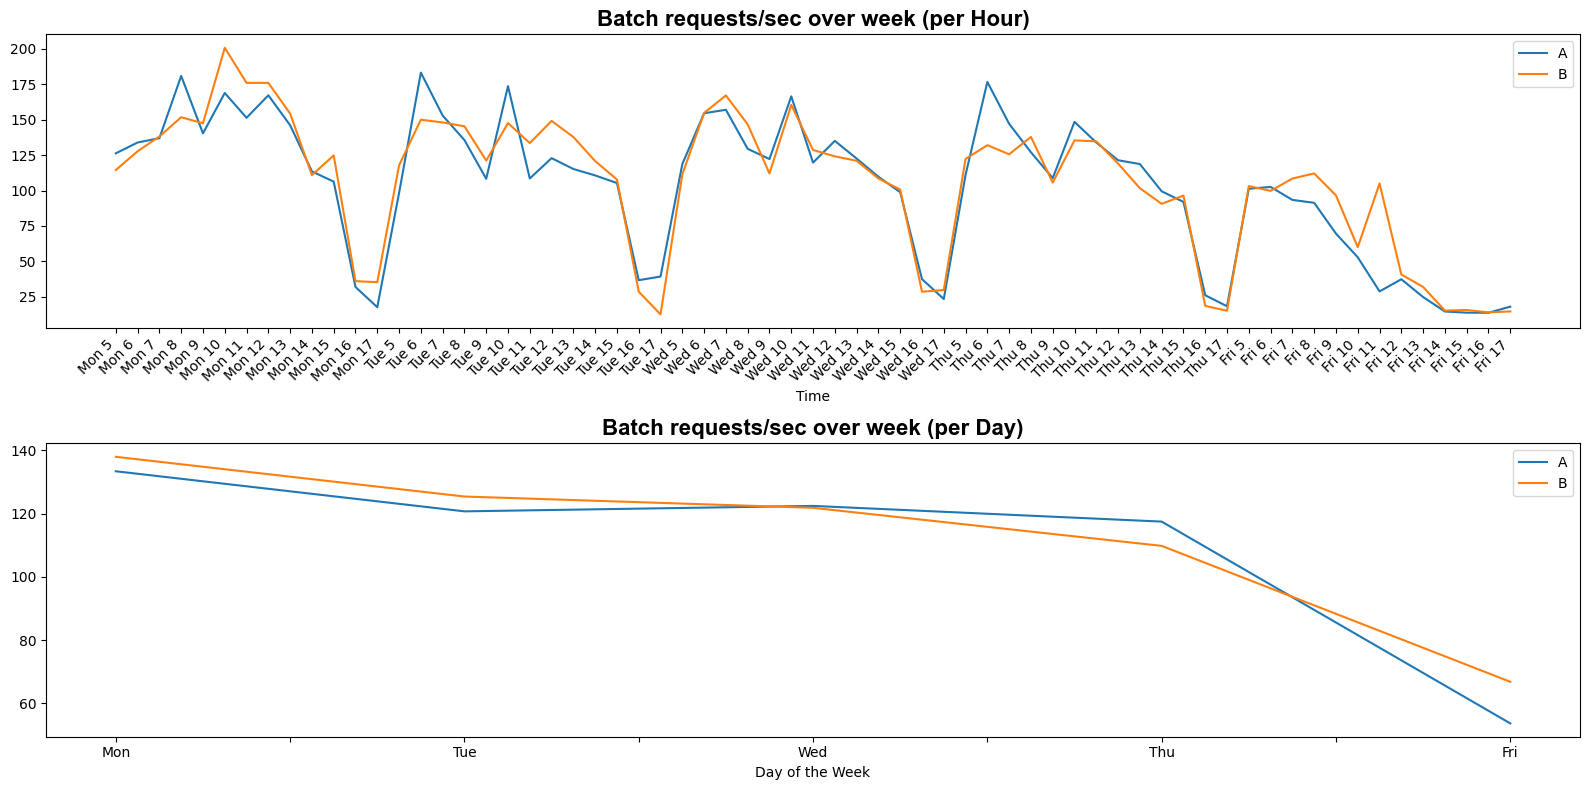

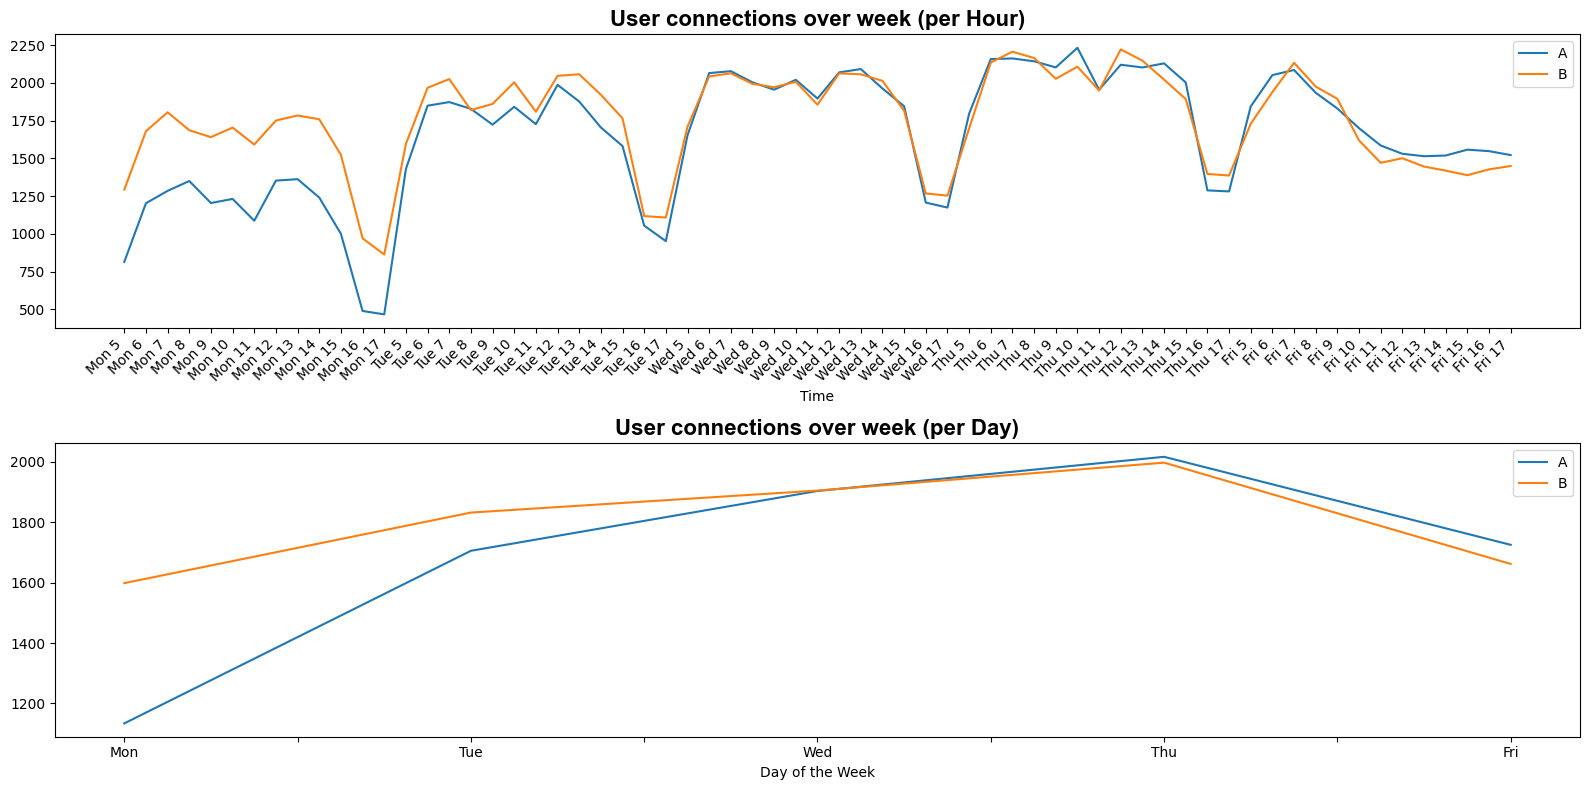

In [89]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,8))
plot_A_vs_B_metric_per_hour('Batch requests/sec', ax1)
plot_A_vs_B_metric_per_day('Batch requests/sec', ax2)
plt.tight_layout()

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(16,8))
plot_A_vs_B_metric_per_hour('User connections', ax1)
plot_A_vs_B_metric_per_day('User connections', ax2)
plt.tight_layout()

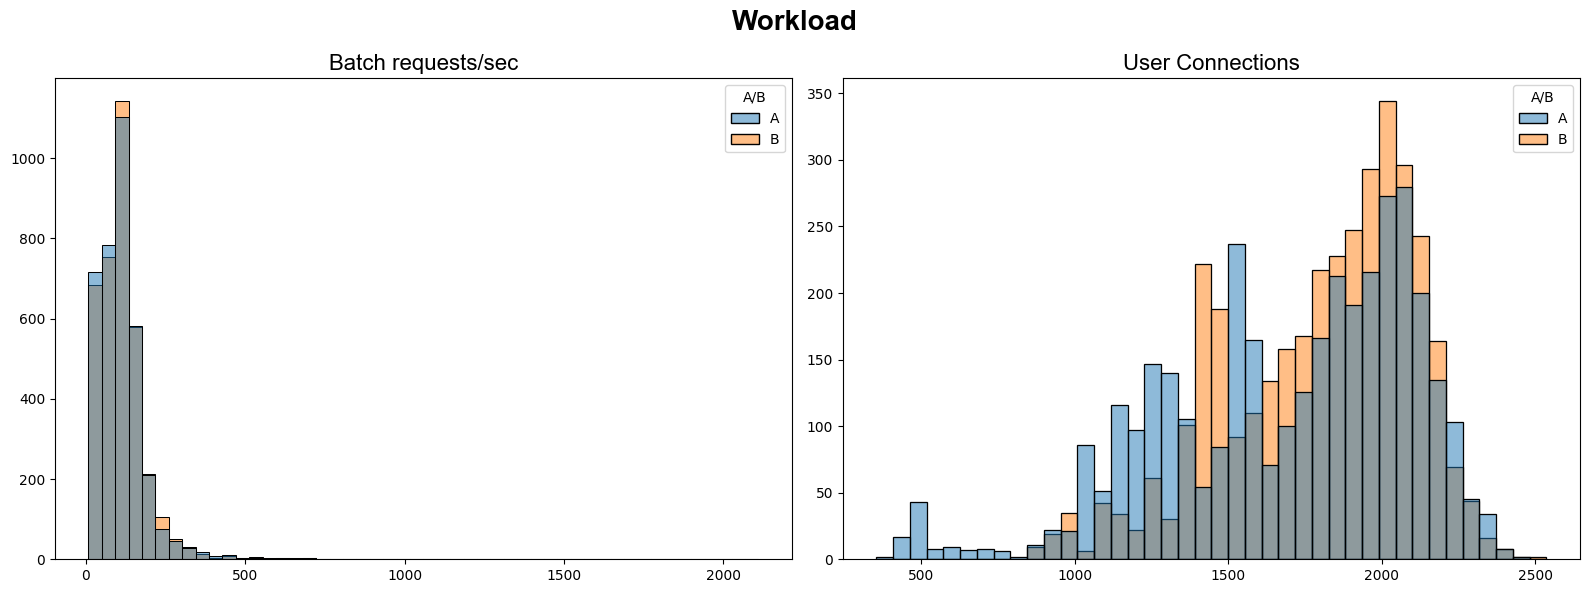

In [90]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))

sns.histplot(data=df_daytime, x='Batch requests/sec', hue='A/B',ax=ax1, bins=50)
sns.histplot(data=df_daytime, x='User connections', hue='A/B', ax=ax2)

plt.suptitle('Workload', fontsize=20, fontweight='bold', fontname='Arial')

ax1.set_title('Batch requests/sec', fontdict=fontdict(fontweight='medium'))
ax2.set_title('User Connections', fontdict=fontdict(fontweight='medium'))

ax1.set_xlabel(None)
ax2.set_xlabel(None)

ax1.set_ylabel(None)
ax2.set_ylabel(None)

plt.tight_layout()

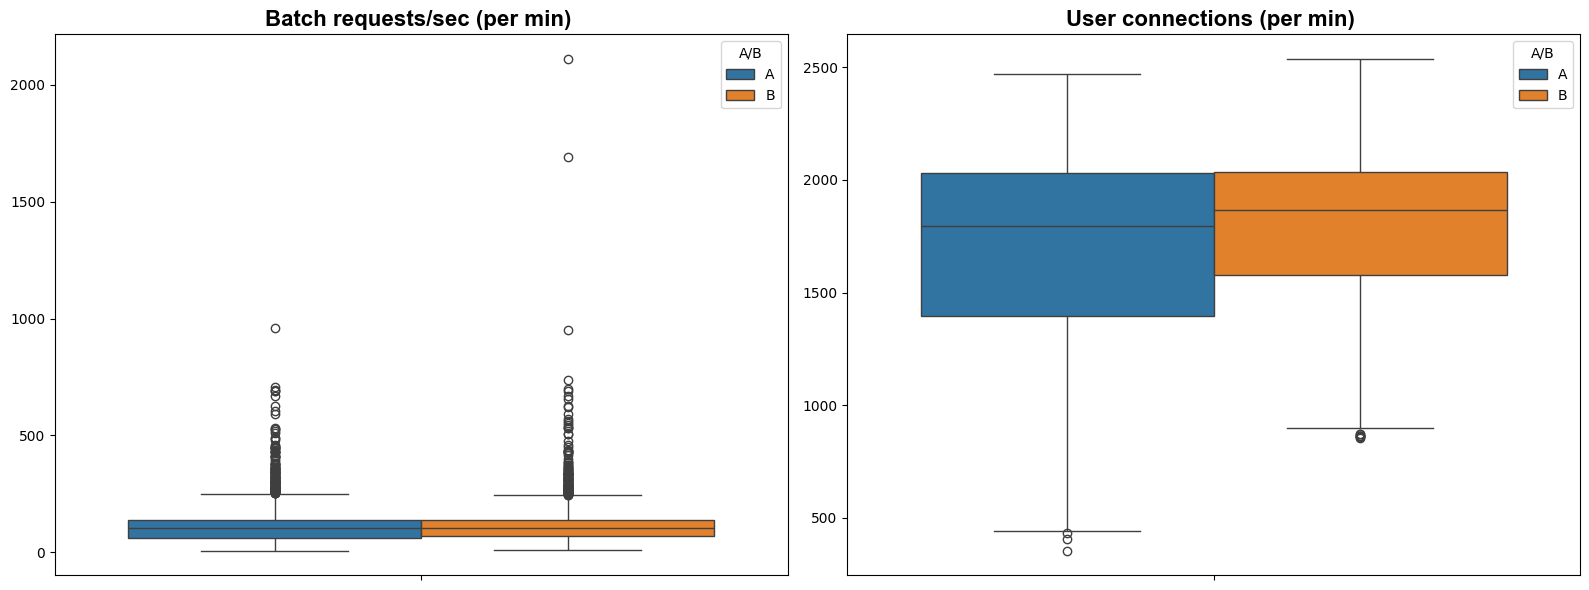

In [91]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(16,6))
plot_boxplot('Batch requests/sec',ax1)
plot_boxplot('User connections', ax2)


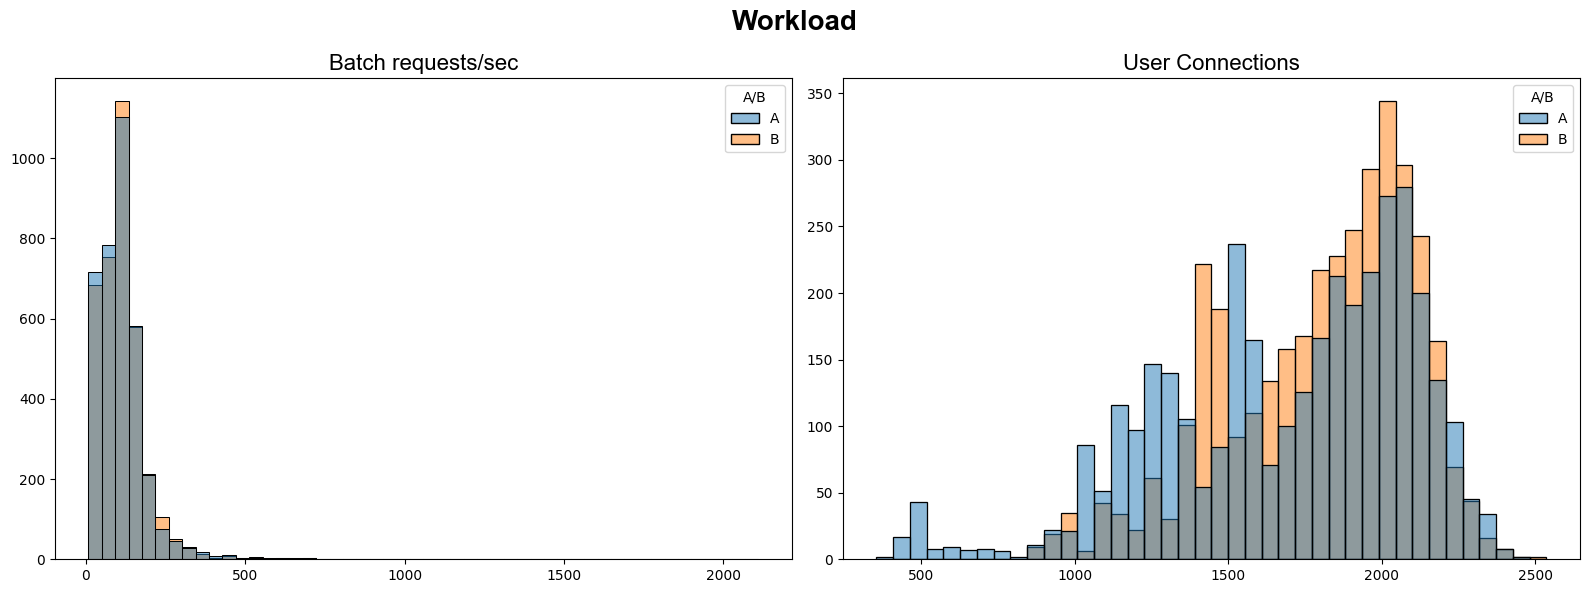

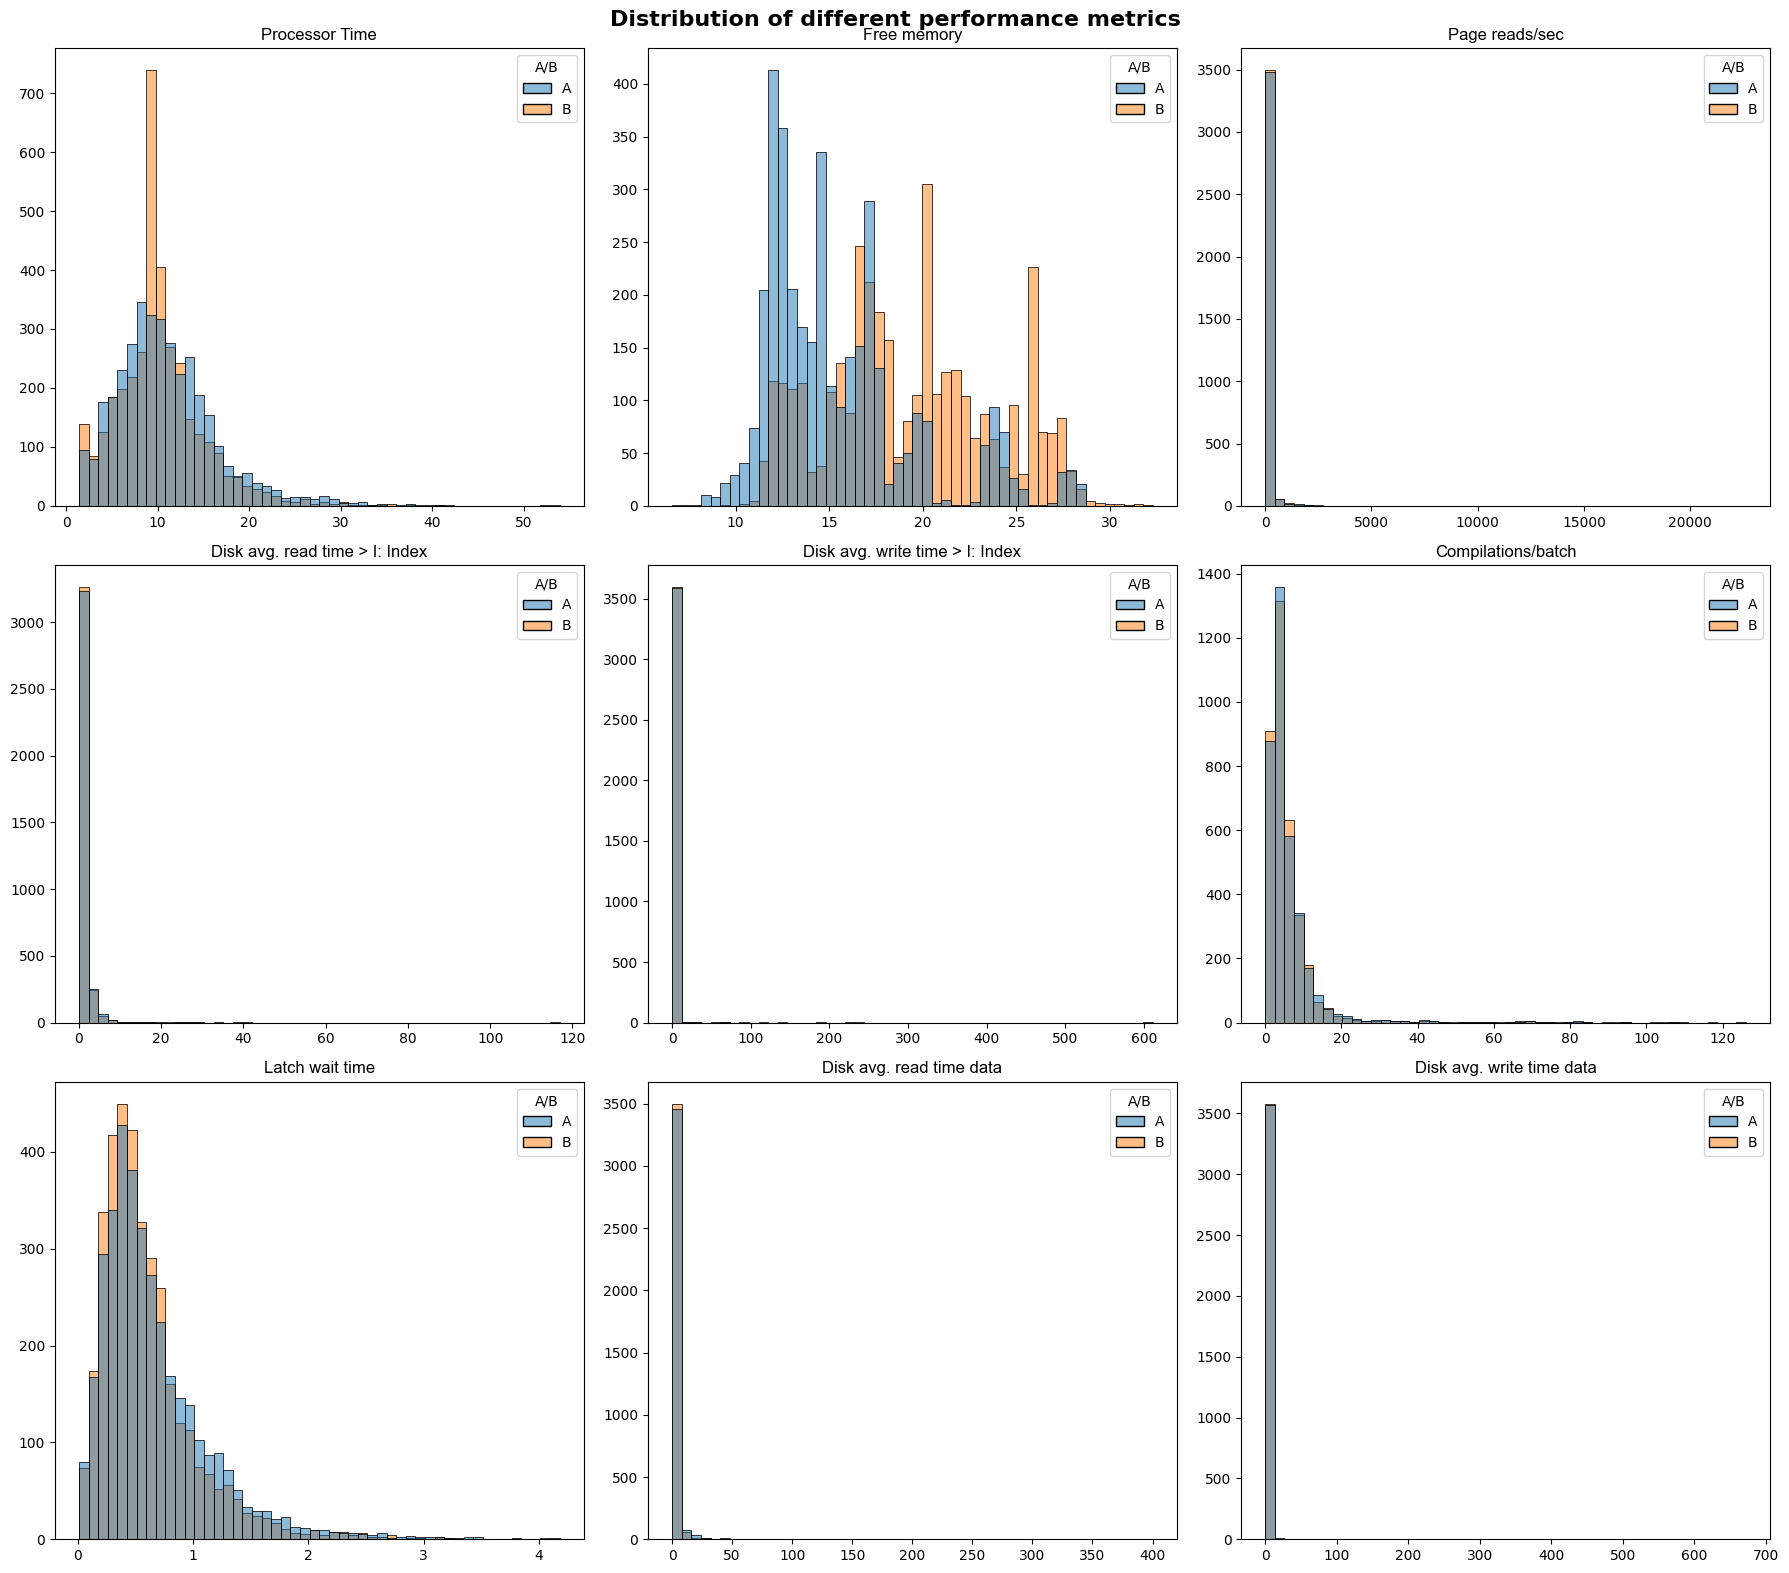

In [92]:

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))

sns.histplot(data=df_daytime, x='Batch requests/sec', hue='A/B',ax=ax1, bins=50)
sns.histplot(data=df_daytime, x='User connections', hue='A/B', ax=ax2)

plt.suptitle('Workload', fontsize=20, fontweight='bold', fontname='Arial')
ax1.set_title('Batch requests/sec', fontdict=fontdict(fontweight='medium'))
ax2.set_title('User Connections', fontdict=fontdict(fontweight='medium'))
ax1.set_xlabel(None)
ax2.set_xlabel(None)
ax1.set_ylabel(None)
ax2.set_ylabel(None)

plt.tight_layout()

fig, axes = plt.subplots(3,3, figsize = (18,16))
axes = axes.flatten()

for i,perf_col in enumerate(perf_cols):
  sns.histplot(data = df_daytime, x= perf_col, hue='A/B', ax=axes[i], bins=50)
  axes[i].set_title(f'{perf_col}', fontdict=fontdict(12,'medium'))
  axes[i].set_xlabel('')
  axes[i].set_ylabel('')

fig.suptitle('Distribution of different performance metrics', fontsize=16, fontweight='bold' )

plt.tight_layout()



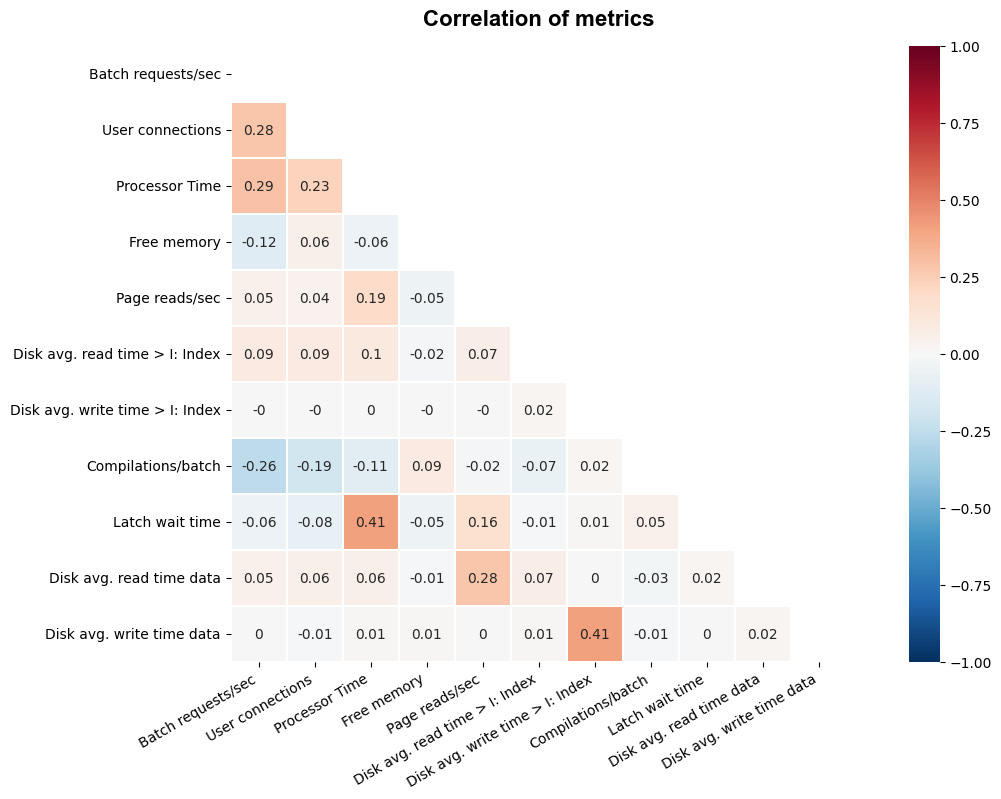

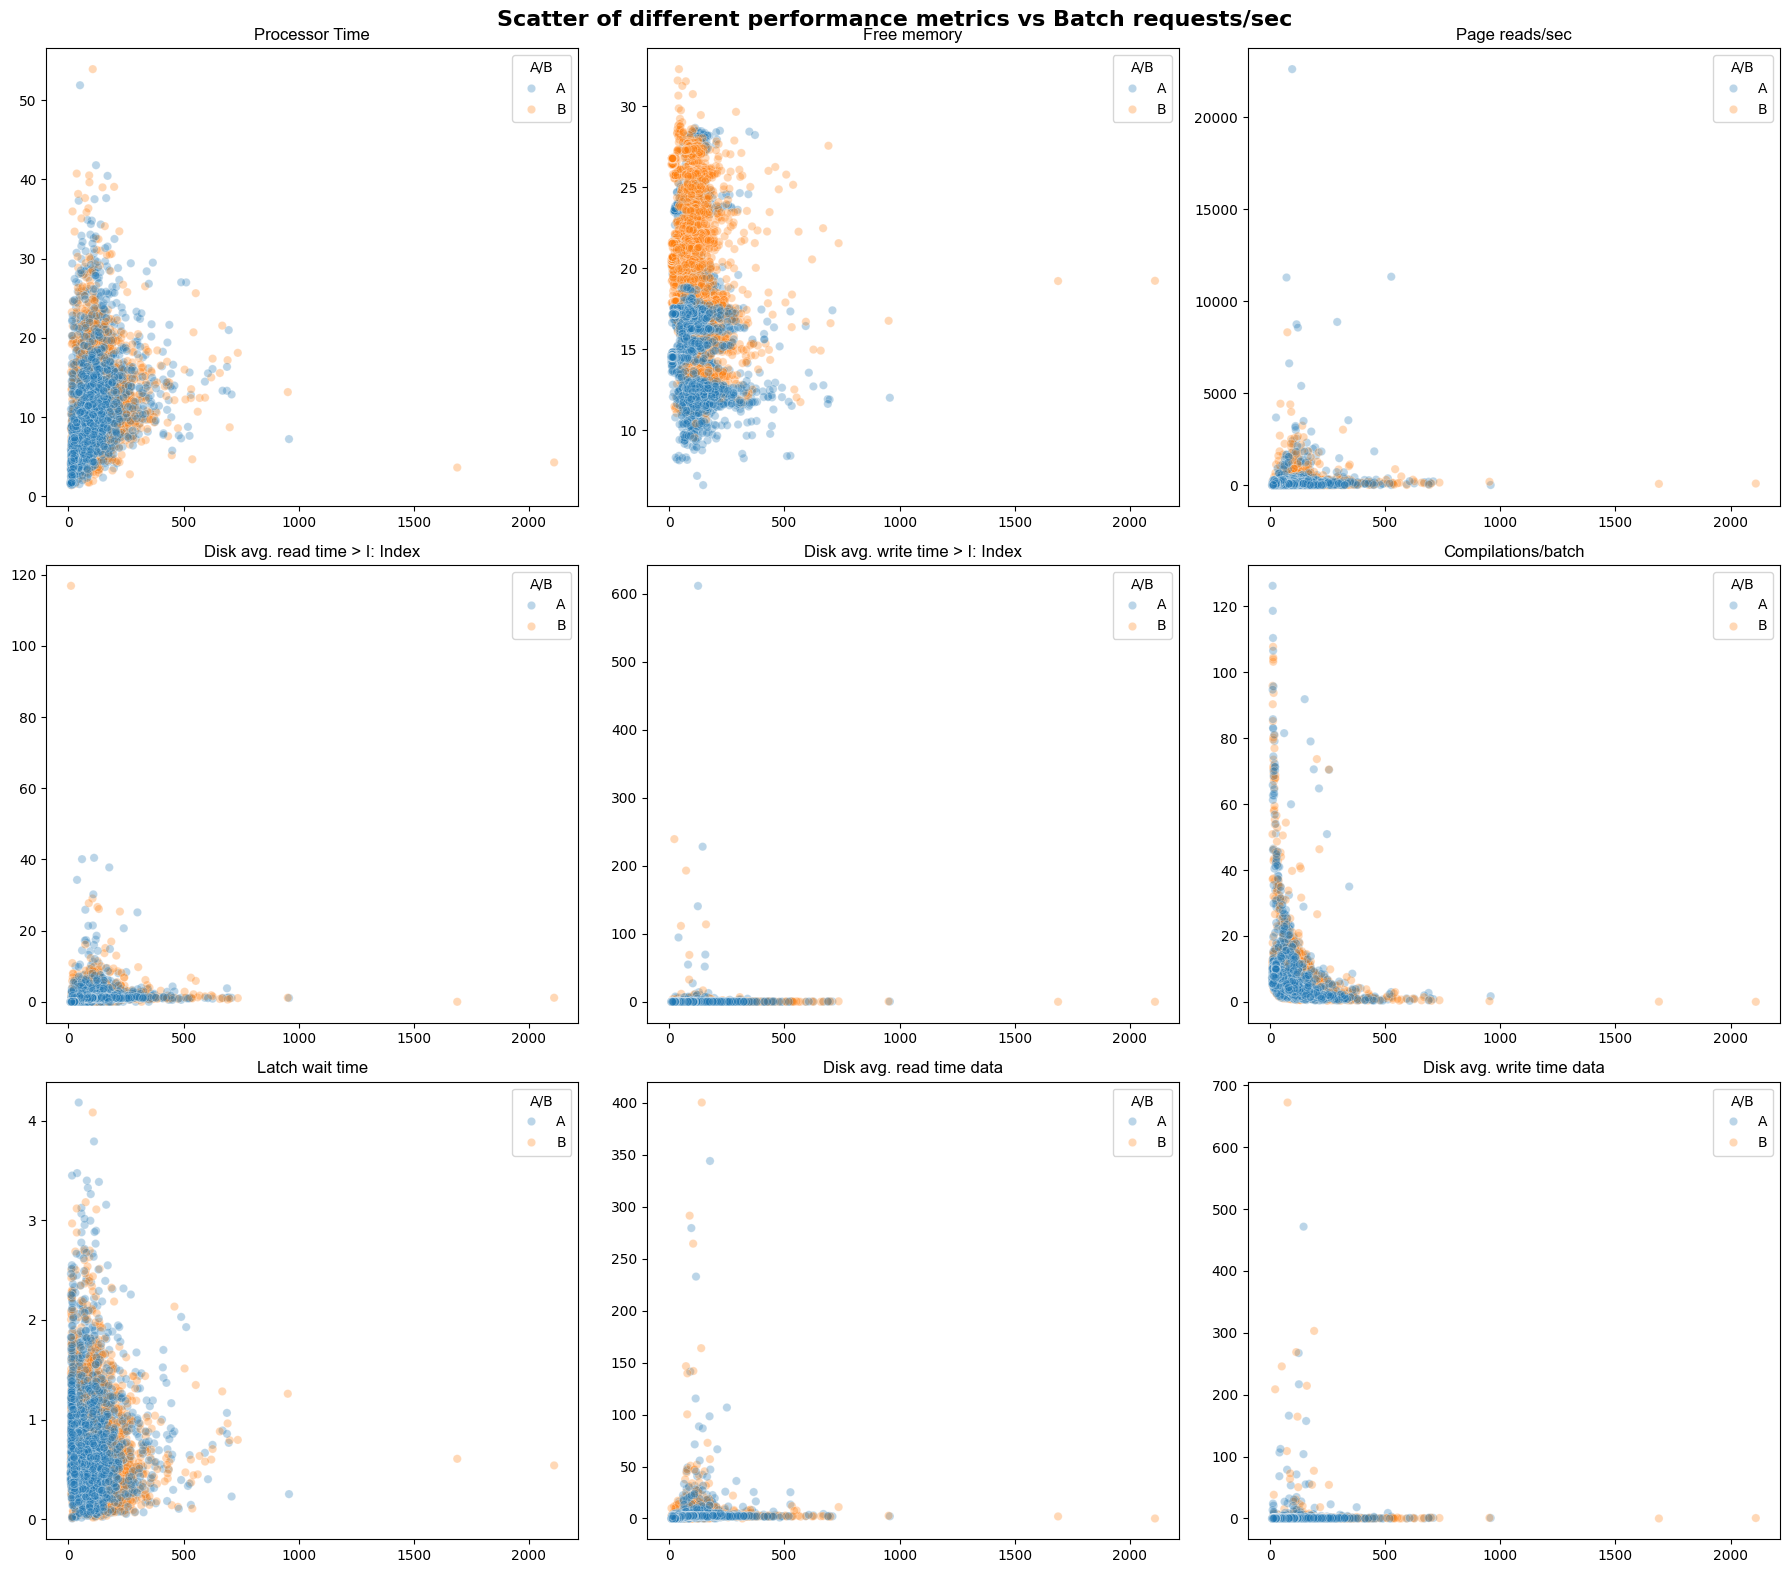

In [93]:

plot_heatmap(df_daytime[metric_cols], title='Correlation of metrics')

fig, axes = plt.subplots(3,3, figsize = (18,16))

axes = axes.flatten()

for i,perf_col in enumerate(perf_cols):
  sns.scatterplot(data = df_daytime, x= 'Batch requests/sec',y=perf_col, hue='A/B', ax=axes[i], alpha=0.3)
  axes[i].set_title(f'{perf_col}', fontdict=fontdict(12,'medium'))
  axes[i].set_xlabel(None)
  axes[i].set_ylabel(None)

fig.suptitle('Scatter of different performance metrics vs Batch requests/sec', fontsize=16, fontweight='bold' )

plt.tight_layout()


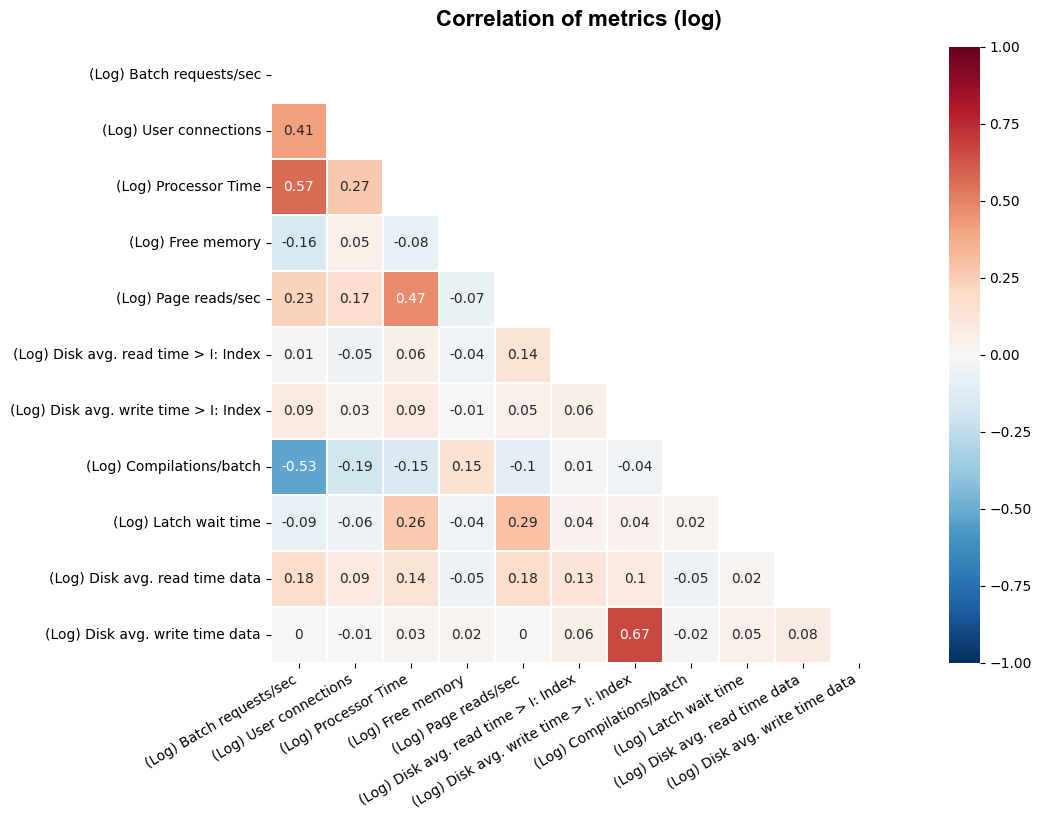

In [94]:
log_metric_cols = ['(Log) '+i for i in metric_cols]
log_perf_cols = ['(Log) ' + i for i in perf_cols]
for i, metric_col in enumerate(metric_cols):
  df_daytime[f'(Log) {metric_col}'] = np.log(df_daytime[metric_col])

plot_heatmap(df_daytime[log_metric_cols], title='Correlation of metrics (log)')


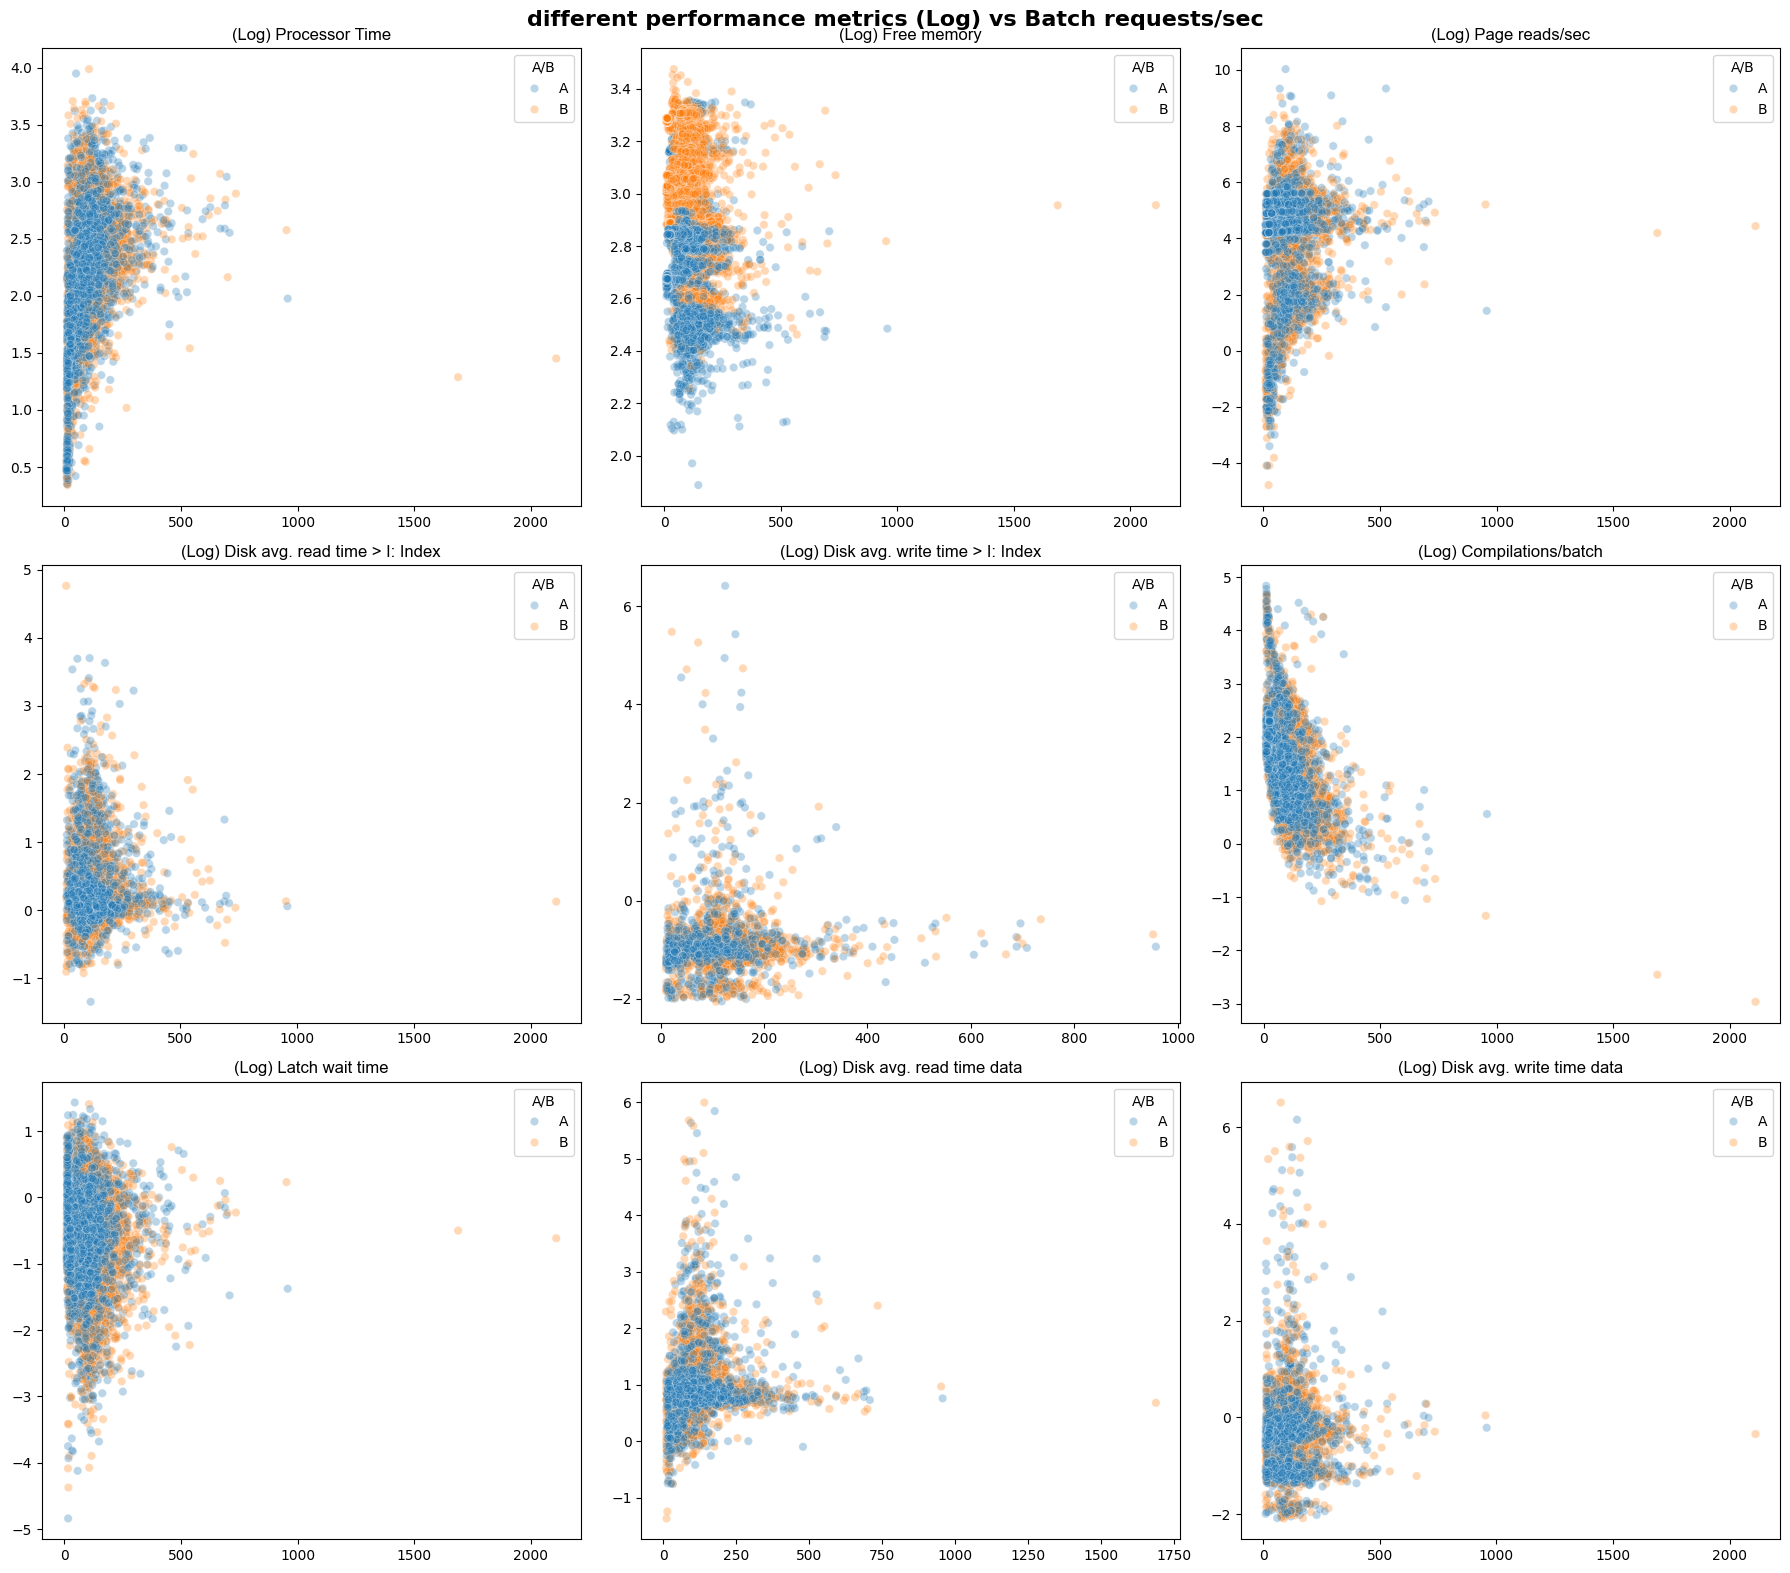

In [95]:
fig, axes = plt.subplots(3,3, figsize = (18,16))

axes = axes.flatten()

for i,log_perf_col in enumerate(log_perf_cols):
  sns.scatterplot(data = df_daytime, x= 'Batch requests/sec',y=log_perf_col, hue='A/B', ax=axes[i], alpha=0.3)
  axes[i].set_title(f'{log_perf_col}', fontdict=fontdict(12,'medium'))
  axes[i].set_xlabel(None)
  axes[i].set_ylabel(None)

fig.suptitle('different performance metrics (Log) vs Batch requests/sec', fontsize=16, fontweight='bold' )

plt.tight_layout()

In [96]:
def plot_workload_vs_performance_per_hour(data,A_or_B, workload_metric, performance_metric, ax1):
    
  workload_mean = data.groupby(['Day_name', 'Hour'])[workload_metric].mean()
  performance_mean = data.groupby(['Day_name', 'Hour'])[performance_metric].mean()
  
  performance_mean.plot(label=f'{performance_metric}', ax=ax1, color='#ffbf00')
  ax1.set_ylabel(f'{performance_metric}', color='#ffbf00')
  ax1.tick_params(axis='y', labelcolor='#ffbf00')

  ax2 = ax1.twinx()

  workload_mean.plot(label=f'{workload_metric}', ax=ax2, color='#247639')
  ax2.set_ylabel(f'{workload_metric}', color='#247639')
  ax2.tick_params(axis='y', labelcolor='#073763')

  ax1.legend(loc='upper left')
  ax2.legend(loc='upper right')
  plt.title(f"{A_or_B}'s {performance_metric} vs {workload_metric} over week (per Hour)", fontdict=fontdict())


def plot_workload_vs_performance_per_day(data, A_or_B, workload_metric, performance_metric, ax1=ax1):
    
  workload_mean = data.groupby(['Day_name'])[workload_metric].mean()
  performance_mean = data.groupby(['Day_name'])[performance_metric].mean()
  
  performance_mean.plot(label=f'{performance_metric}', ax=ax1, color='#ffbf00')
  ax1.set_ylabel(f'{performance_metric}', color='#ffbf00')
  ax1.tick_params(axis='y', labelcolor='#ffbf00')

  ax2 = ax1.twinx()

  workload_mean.plot(label=f'{workload_metric}', ax=ax2, color='#247639')
  ax2.set_ylabel(f'{workload_metric}', color='#247639')
  ax2.tick_params(axis='y', labelcolor='#073763')

  ax1.legend(loc='upper left')
  ax2.legend(loc='upper right')
  plt.title(f"{A_or_B}'s {performance_metric} vs {workload_metric} over week (per day)", fontdict=fontdict())

def plot_workload_vs_performance_per_minute(data, A_or_B, workload_metric, performance_metric, ax1=ax1):
    
  workload_mean = data[workload_metric]
  performance_mean = data[performance_metric]
  
  performance_mean.plot(label=f'{performance_metric}', ax=ax1, color='#ffbf00')
  ax1.set_ylabel(f'{performance_metric}', color='#ffbf00')
  ax1.tick_params(axis='y', labelcolor='#ffbf00')

  ax2 = ax1.twinx()

  workload_mean.plot(label=f'{workload_metric}', ax=ax2, color='#247639')
  ax2.set_ylabel(f'{workload_metric}', color='#247639')
  ax2.tick_params(axis='y', labelcolor='#073763')

  ax1.legend(loc='upper left')
  ax2.legend(loc='upper right')
  plt.title(f"{A_or_B}'s {performance_metric} vs {workload_metric} over week (per day)", fontdict=fontdict())

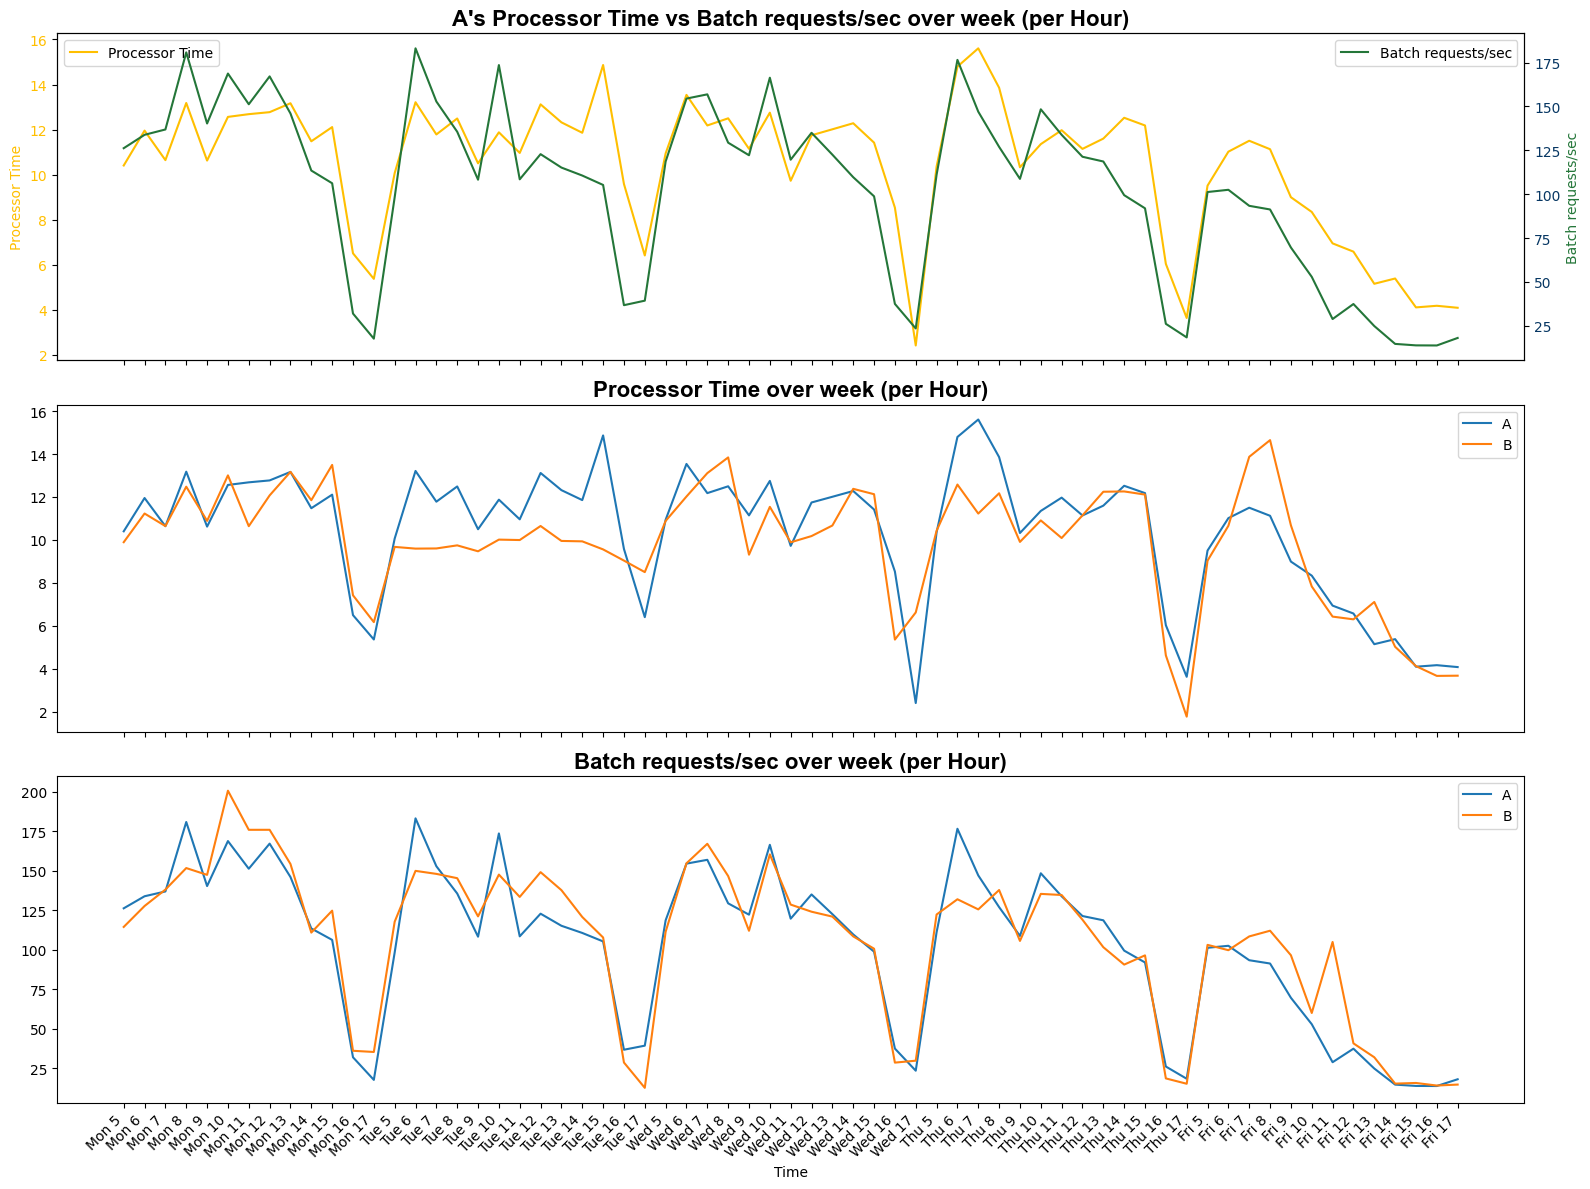

In [97]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(16,12), sharex=True)

plot_workload_vs_performance_per_hour(df_A_daytime,"A", 'Batch requests/sec','Processor Time', ax1)
plot_A_vs_B_metric_per_hour('Processor Time', ax2)
plot_A_vs_B_metric_per_hour('Batch requests/sec', ax3)
plt.tight_layout()

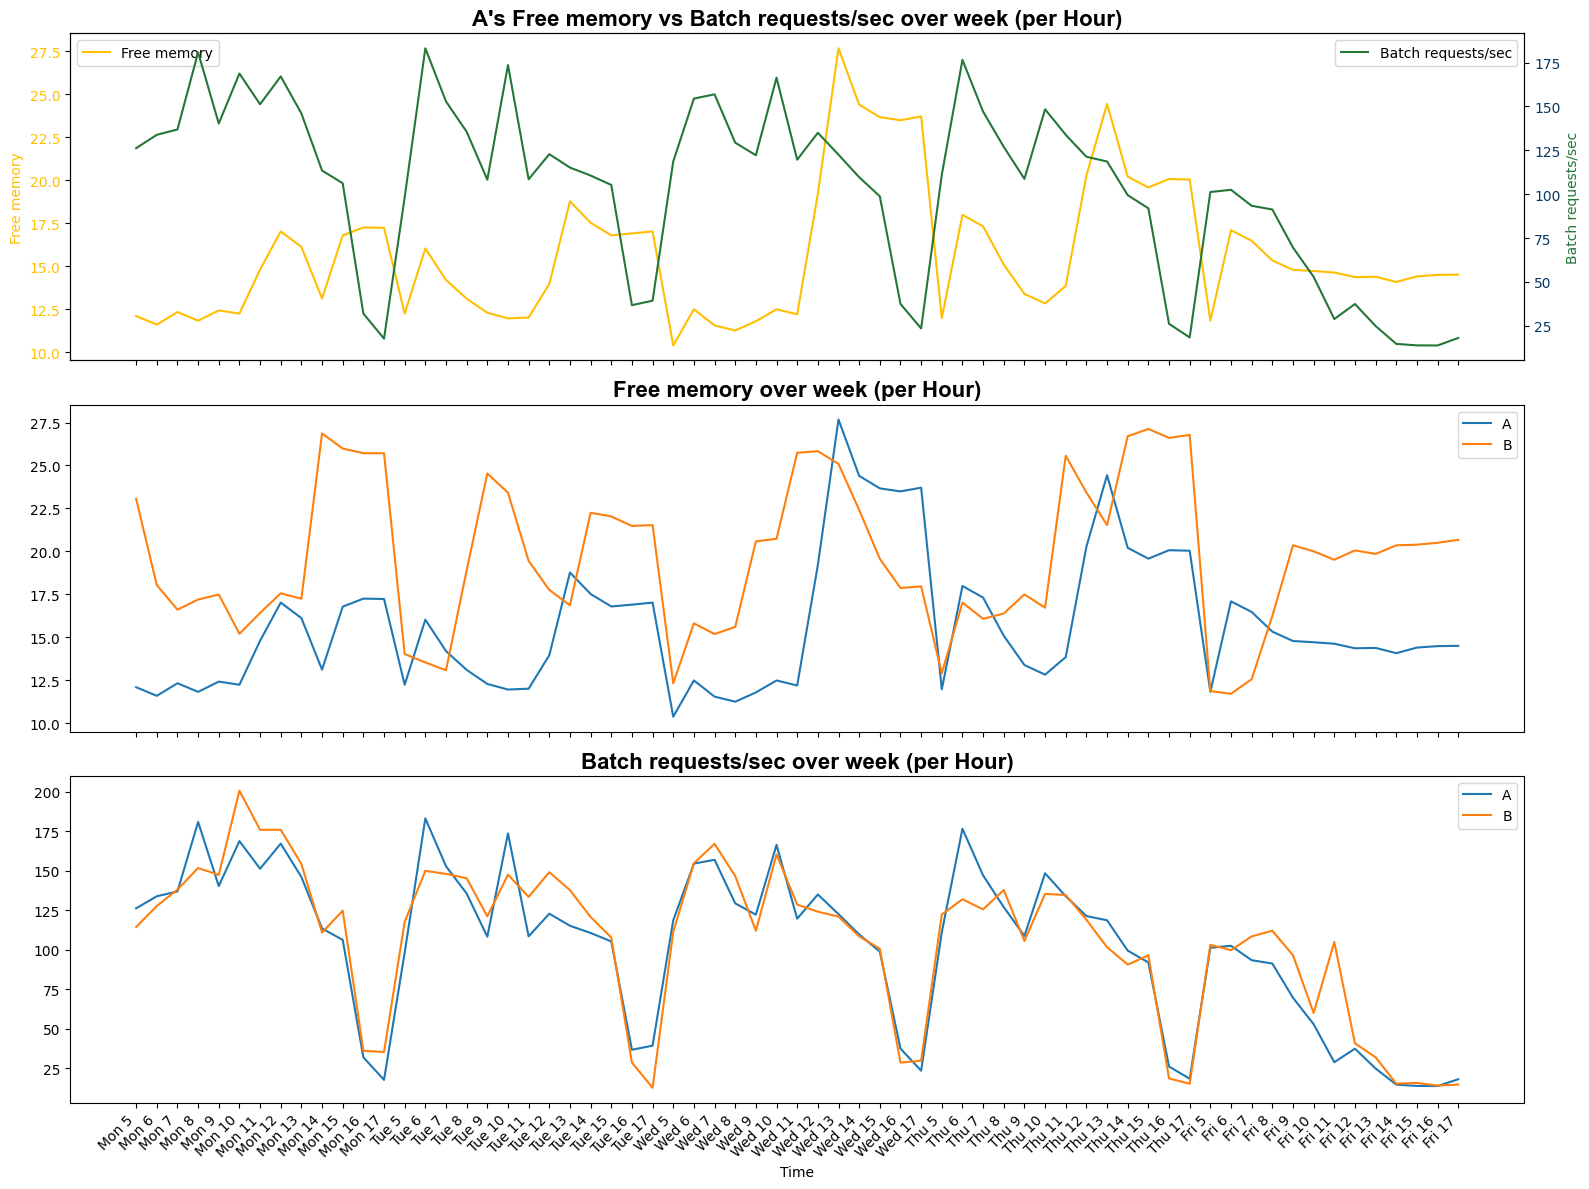

In [98]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1,figsize=(16,12), sharex=True)

plot_workload_vs_performance_per_hour(df_A_daytime, 'A','Batch requests/sec','Free memory', ax1)

plot_A_vs_B_metric_per_hour('Free memory', ax2)
plot_A_vs_B_metric_per_hour('Batch requests/sec', ax3)

plt.tight_layout()


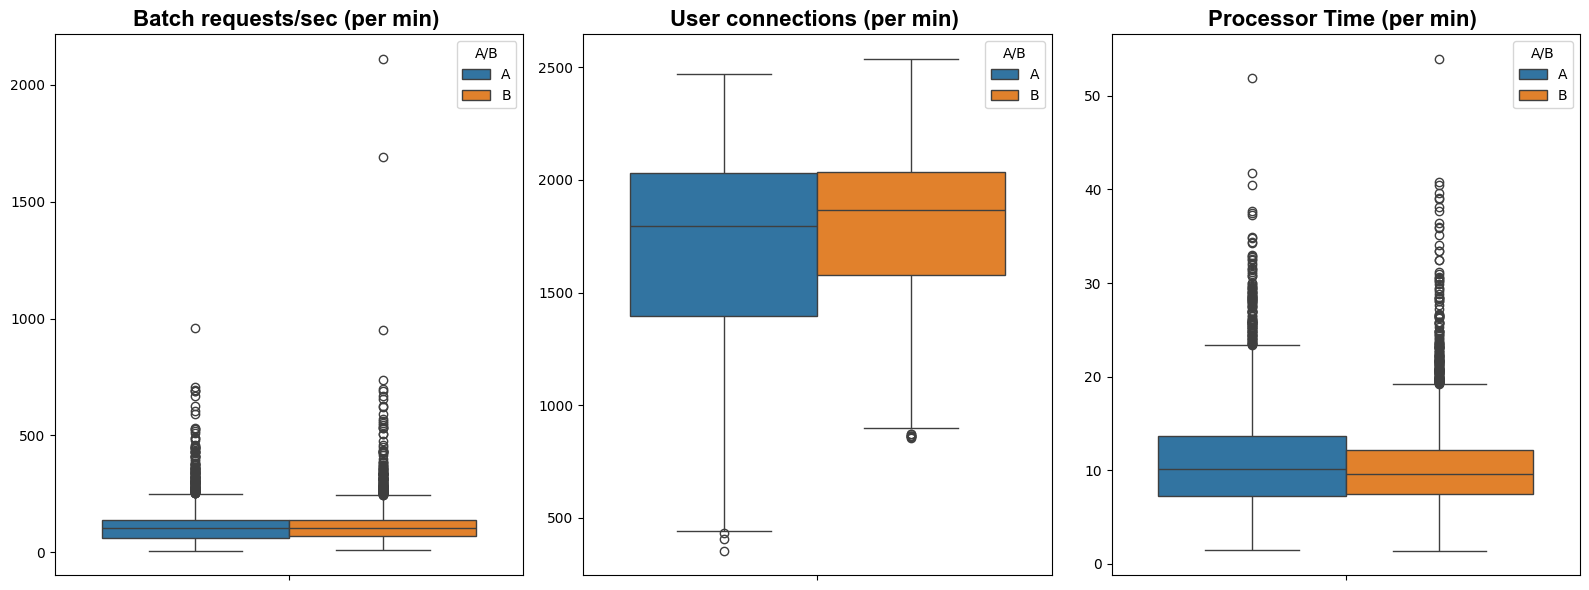

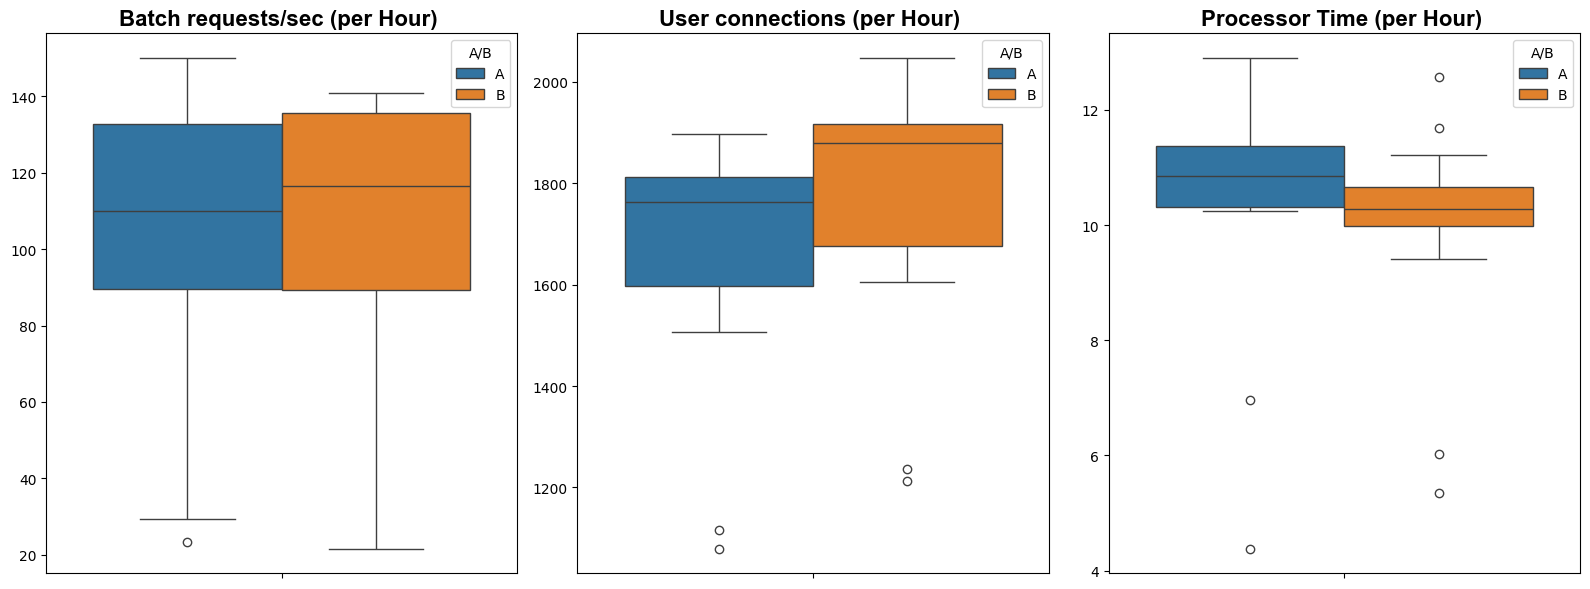

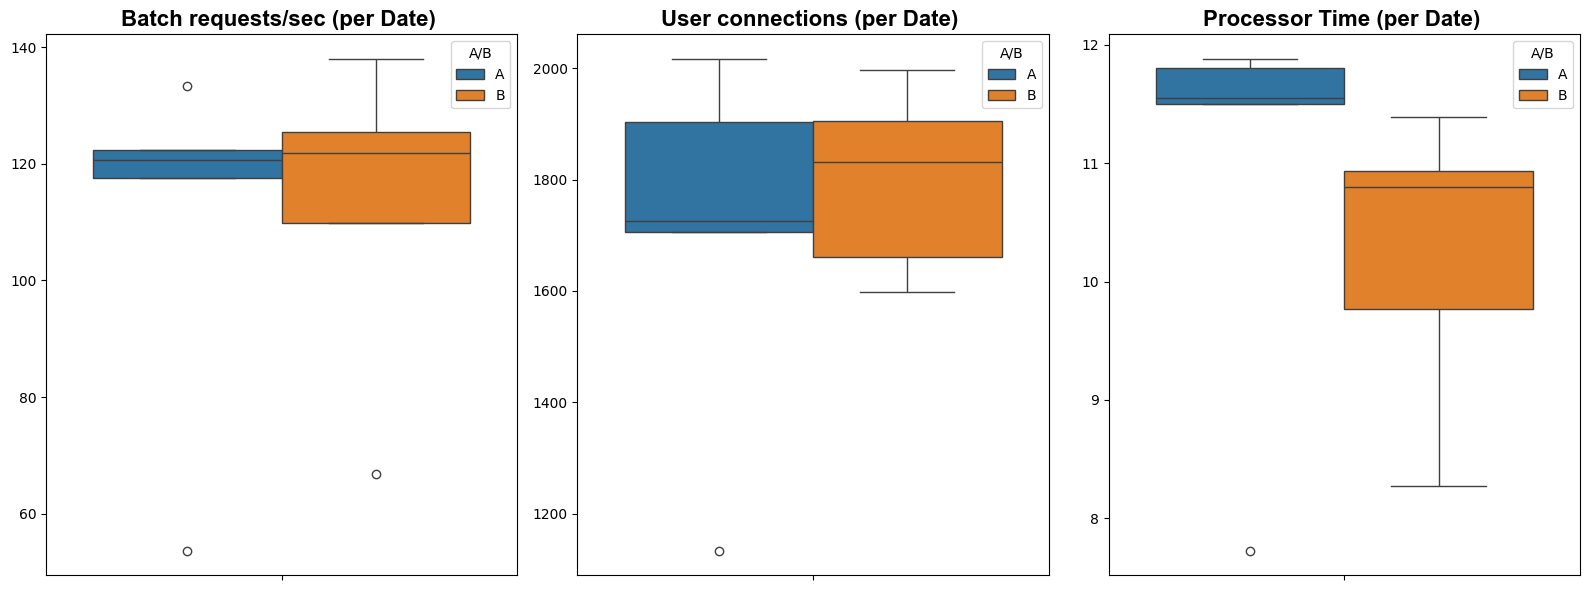

In [99]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,6))
plot_boxplot('Batch requests/sec', ax1)
plot_boxplot('User connections', ax2)
plot_boxplot('Processor Time', ax3)
plt.tight_layout()
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,6))
plot_boxplot('Batch requests/sec', ax1, 'Hour')
plot_boxplot('User connections', ax2,'Hour')
plot_boxplot('Processor Time', ax3,'Hour')
plt.tight_layout()
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(16,6))
plot_boxplot('Batch requests/sec', ax1, 'Date')
plot_boxplot('User connections', ax2,'Date')
plot_boxplot('Processor Time', ax3,'Date')
plt.tight_layout()

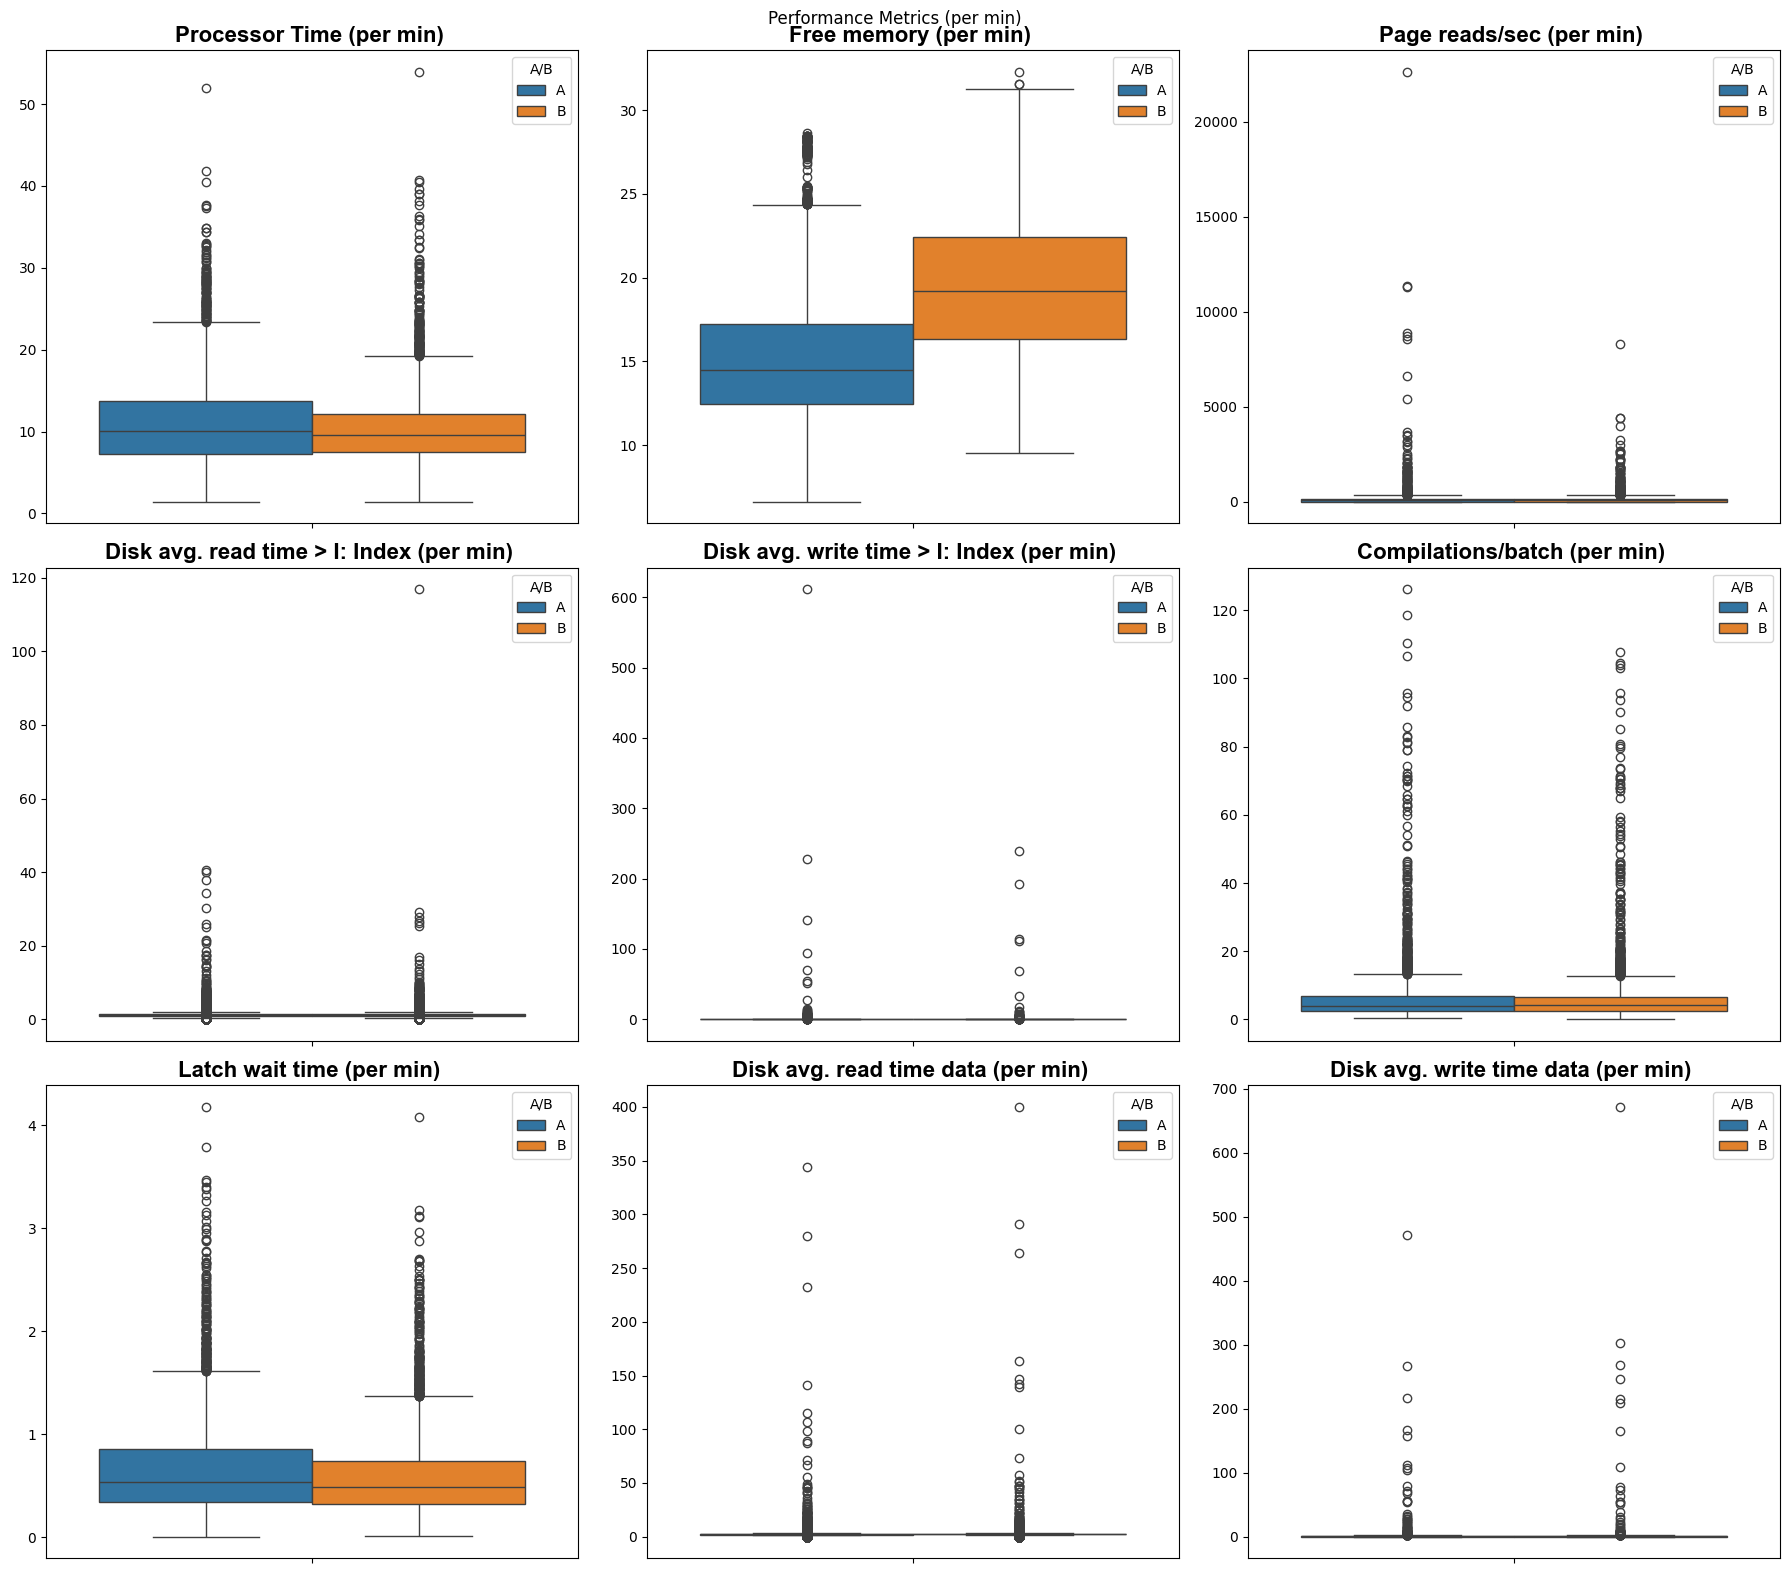

In [100]:
fig, axes = plt.subplots(3,3, figsize = (18,16))
axes = axes.flatten()
for i,perf_col in enumerate(perf_cols):
  plot_boxplot(perf_col,axes[i])
fig.suptitle('Performance Metrics (per min)')
plt.tight_layout()
plt.show()


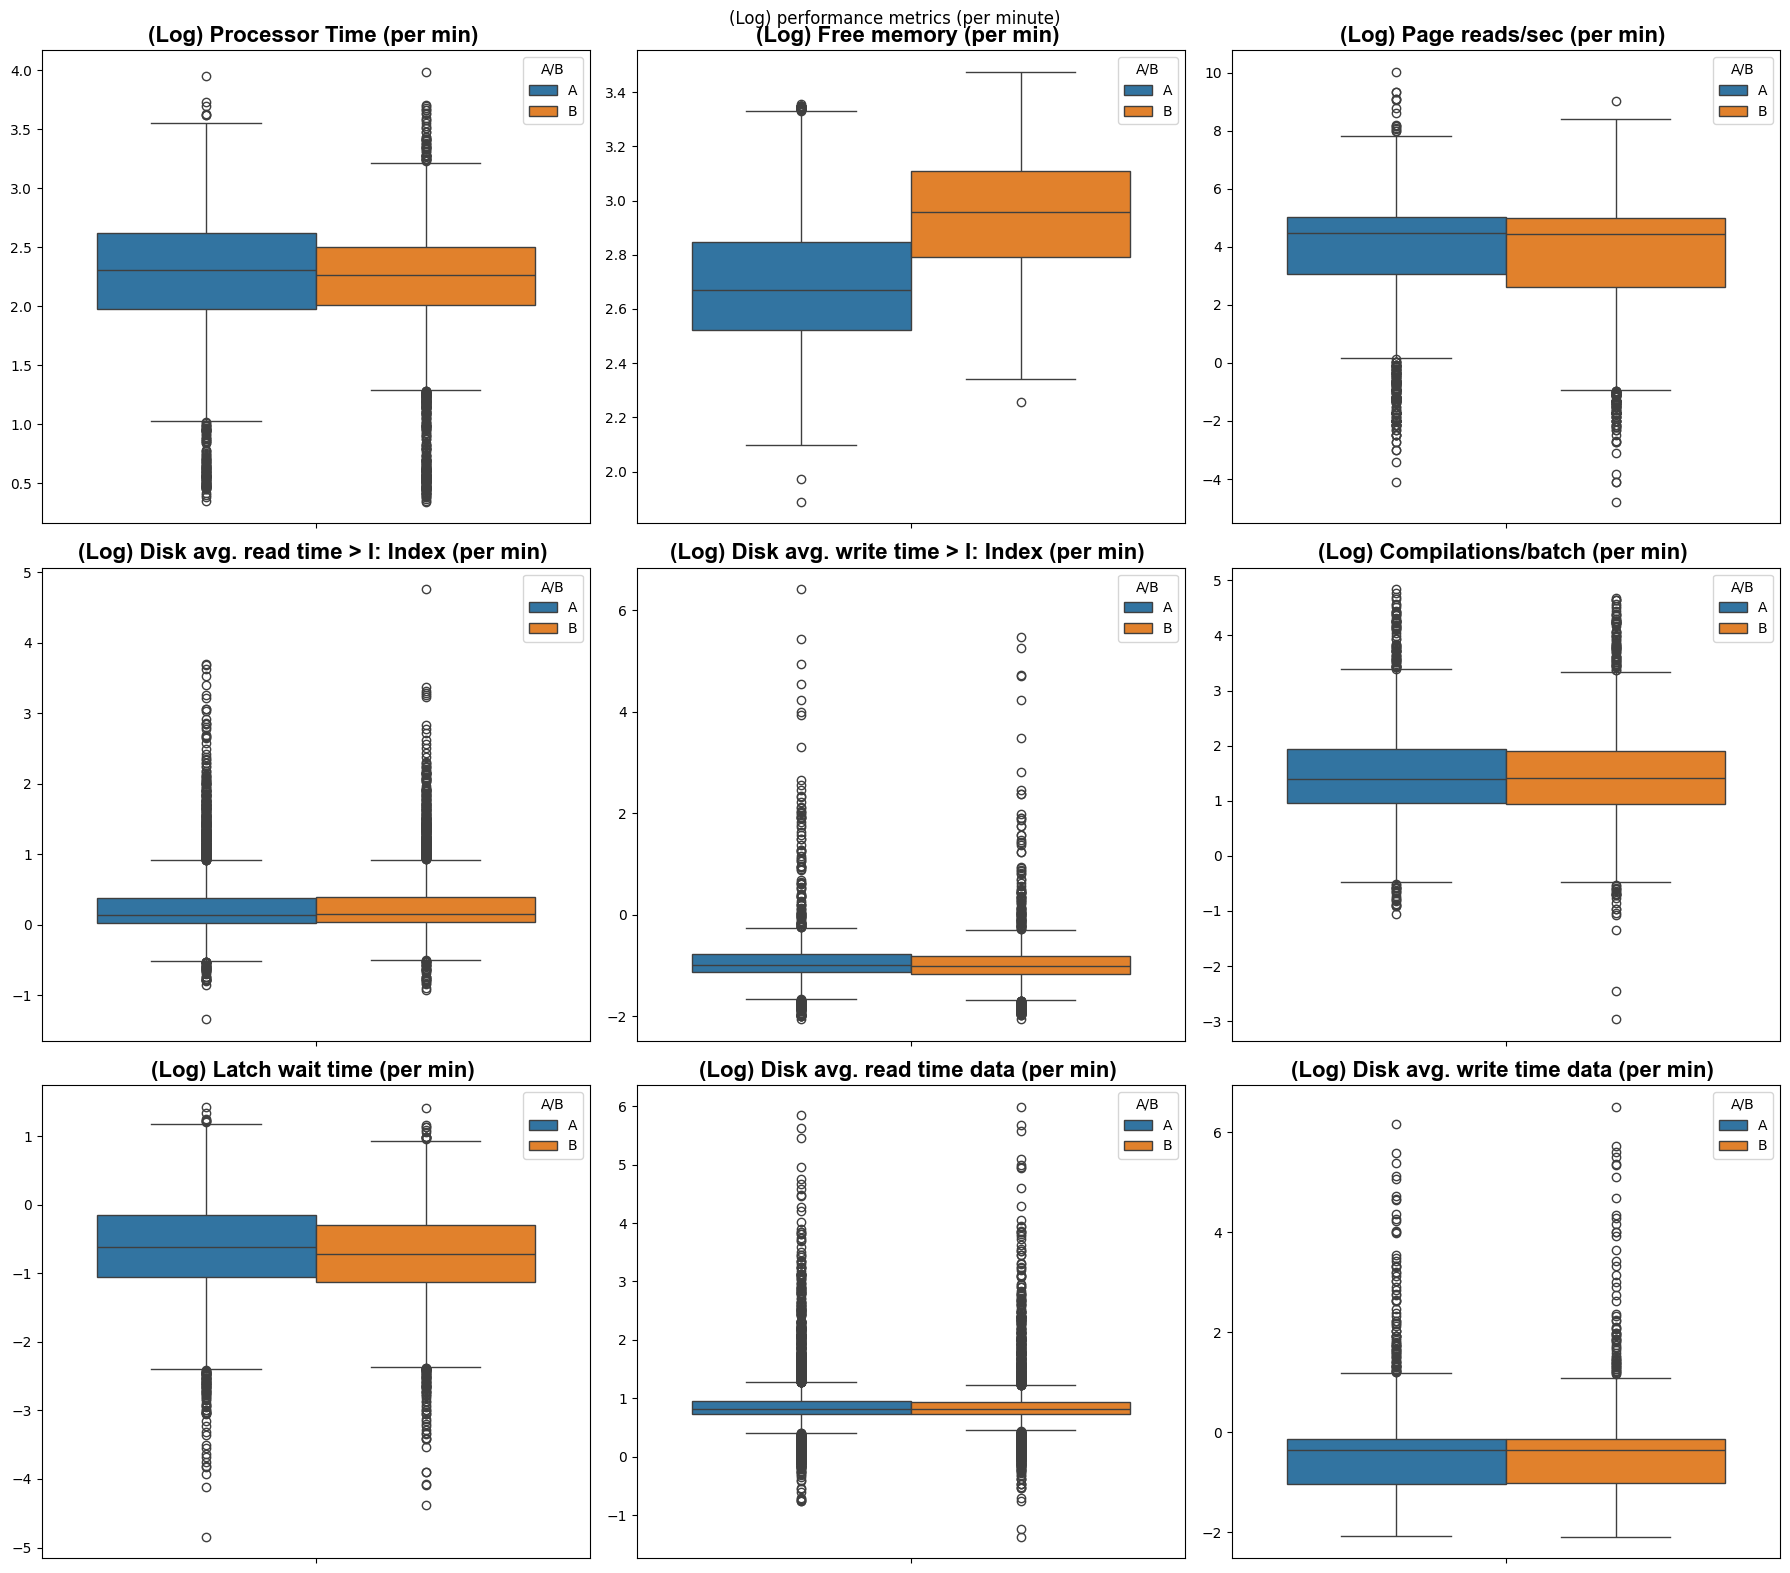

In [101]:
fig, axes = plt.subplots(3,3, figsize = (18,16))
axes = axes.flatten()
for i,perf_col in enumerate(perf_cols):
  plot_boxplot('(Log) '+perf_col,axes[i])
fig.suptitle('(Log) performance metrics (per minute)')
plt.tight_layout()
plt.show()


In [102]:
df_A_daytime = df_A_daytime.reset_index(drop=True)


In [103]:
df_B_daytime = df_B_daytime[:-3]


In [108]:
df_B_daytime = df_B_daytime.reset_index(drop=True)

In [142]:
def permutation_test(metric, df1, df2):
    combined_free_memory = np.concatenate([df1[metric].values, df2[metric].values])
    n_simulations = 1000

    size_1 = len(df1)

    simulated_diffs = []

    for i in range(n_simulations):
        np.random.shuffle(combined_free_memory)
        simulated_A = combined_free_memory[:size_1]
        simulated_B = combined_free_memory[size_1:]
        simulated_diff = np.mean(simulated_A) - np.mean(simulated_B)
        simulated_diffs.append(simulated_diff)

    real_diff = np.mean(df1[metric]) - np.mean(df2[metric])

    upper_bound = np.quantile(simulated_diffs, 0.975)
    lower_bound = np.quantile(simulated_diffs, 0.025)

    return upper_bound, lower_bound, real_diff





In [157]:
significant_diffs = []
for col in perf_cols:
  upper_bound, lower_bound, real_diff = permutation_test(col,df_A_daytime, df_B_daytime)
  print(col)
  print(f"Lower Bound: {lower_bound}")
  print(f"Upper Bound: {upper_bound}")
  print(f"real_diff: {real_diff}")
  if real_diff > upper_bound or  real_diff <lower_bound:
      
      print('The difference between two samples are significant\n')
      significant_diffs.append(col)
  else: 
        print('The difference is not significance\n')
        print(metric_col)

Processor Time
Lower Bound: -0.25430896803791814
Upper Bound: 0.2449674521102087
real_diff: 0.6531331109480334
The difference between two samples are significant

Free memory
Lower Bound: -0.20008258205160628
Upper Bound: 0.22715789203807737
real_diff: -3.9152791956271518
The difference between two samples are significant

Page reads/sec
Lower Bound: -21.301141282159833
Upper Bound: 21.692923224817097
real_diff: 27.05335925087202
The difference between two samples are significant

Disk avg. read time > I: Index
Lower Bound: -0.10077468342127187
Upper Bound: 0.10580426895306858
real_diff: -0.018125659539017125
The difference is not significance

Disk avg. write time data
Disk avg. write time > I: Index
Lower Bound: -0.38629835878922525
Upper Bound: 0.40327422174395977
real_diff: 0.15471452374340455
The difference is not significance

Disk avg. write time data
Compilations/batch
Lower Bound: -0.4100243491565372
Upper Bound: 0.3787366648881402
real_diff: 0.13637753738282843
The difference

In [156]:
significant_diffs

['Processor Time', 'Free memory', 'Page reads/sec', 'Latch wait time']